<a href="https://colab.research.google.com/github/Pradeep-192006/Computer-vision-/blob/main/object_detection_2D_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

'MobileNetSSD_deploy (1).caffemodel'   sample_data
 MobileNetSSD_deploy.prototxt


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot (9).png to Screenshot (9).png


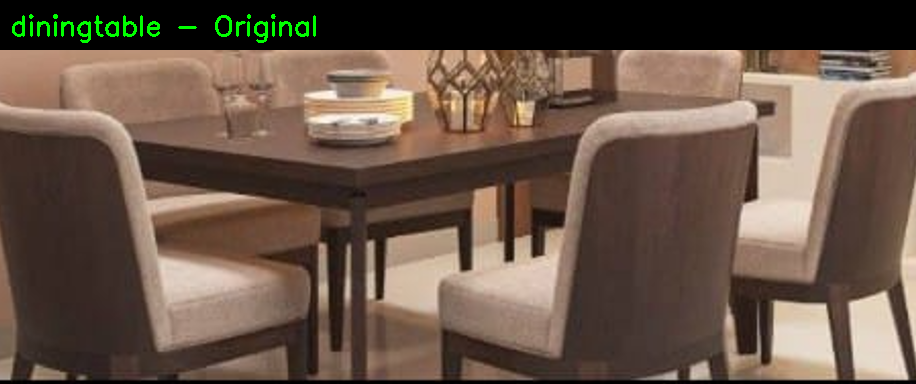

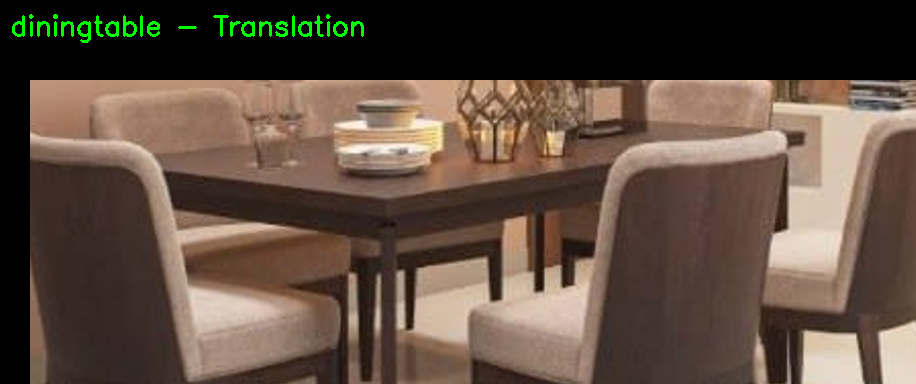

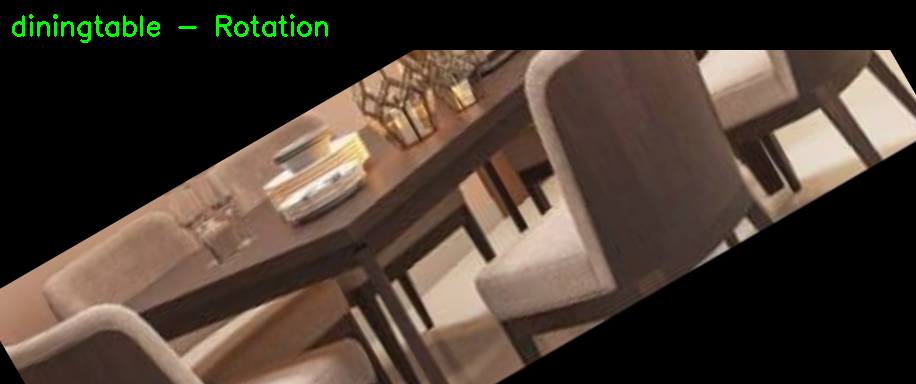

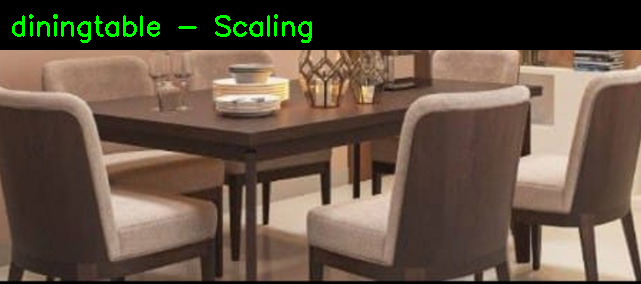

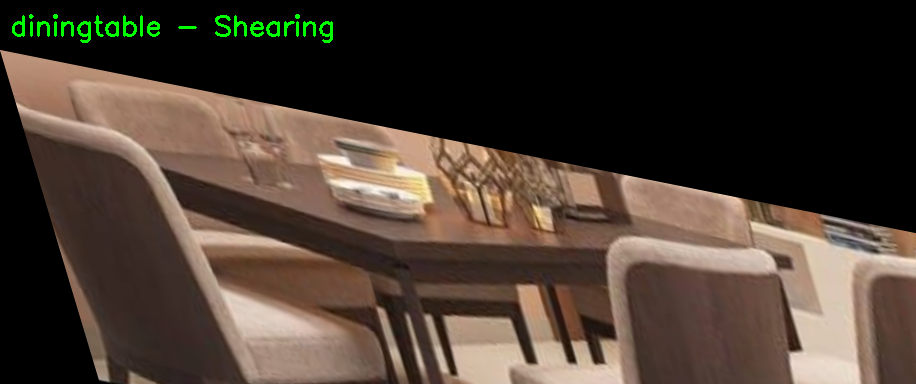

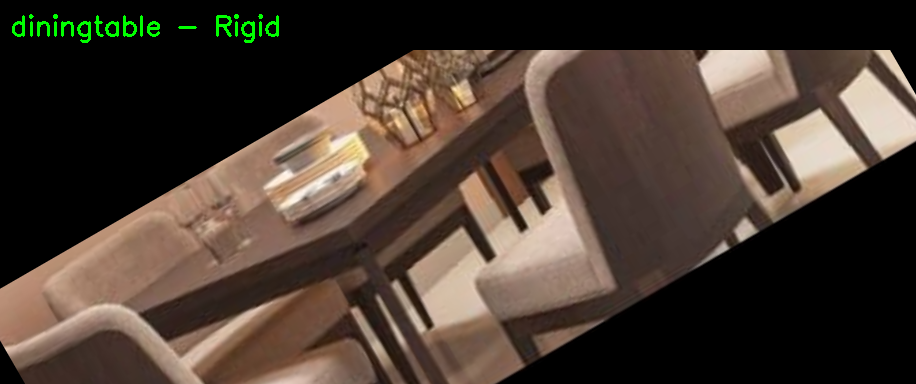

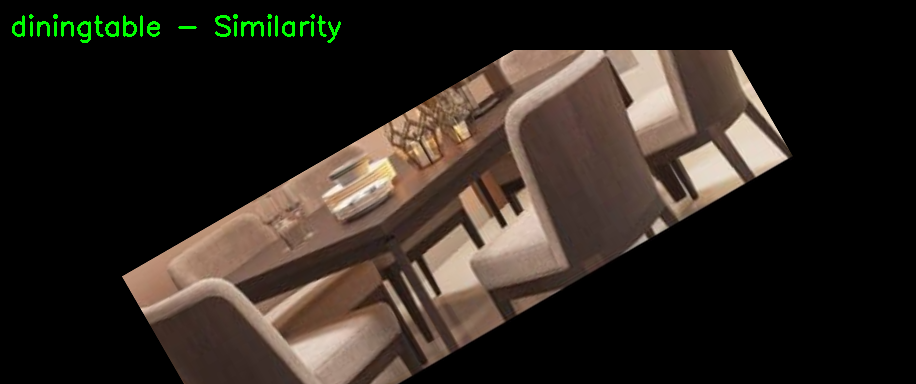

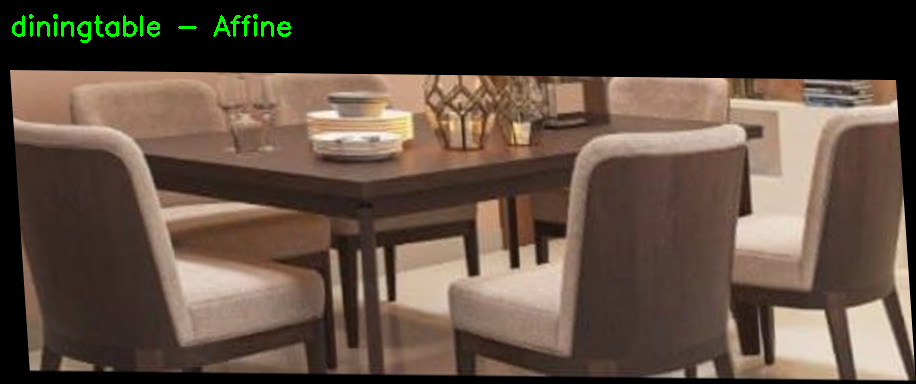

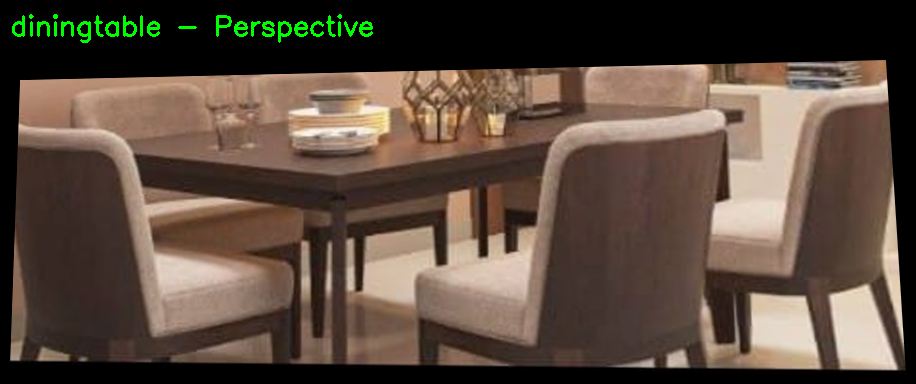

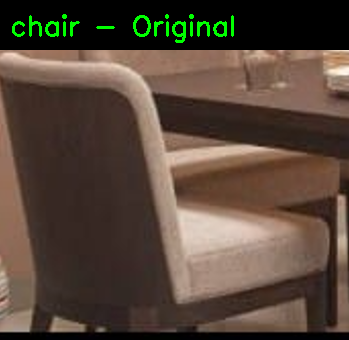

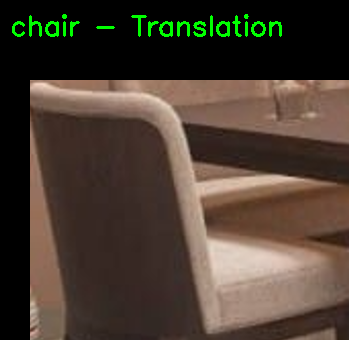

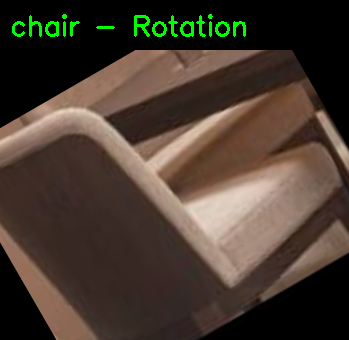

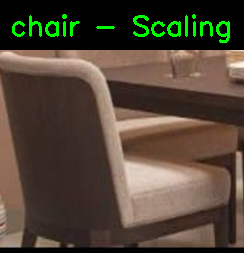

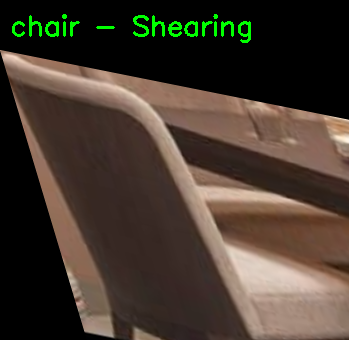

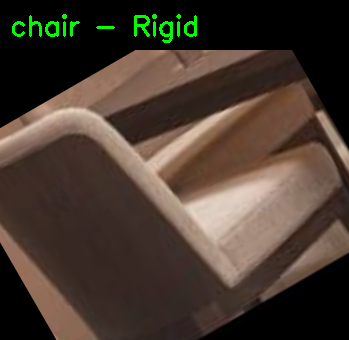

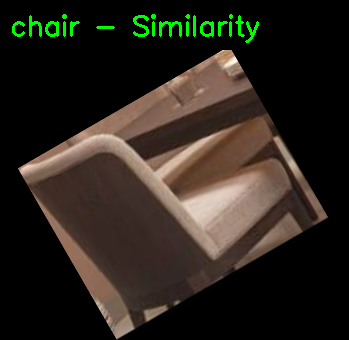

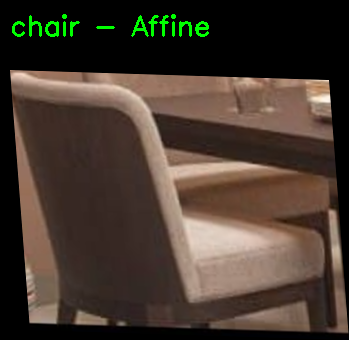

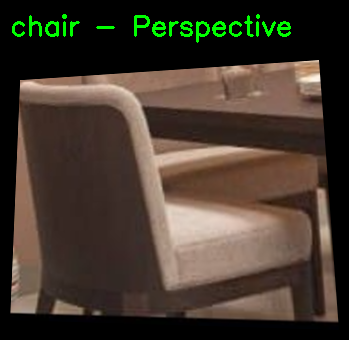

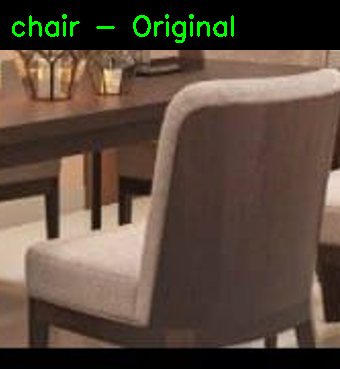

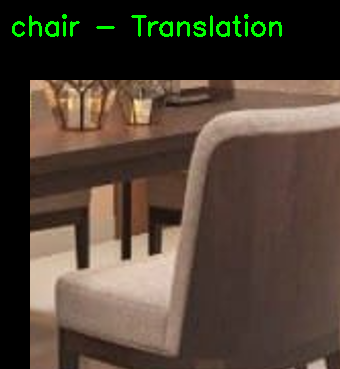

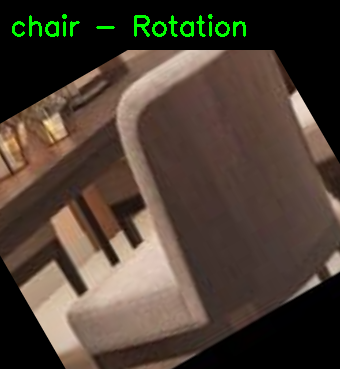

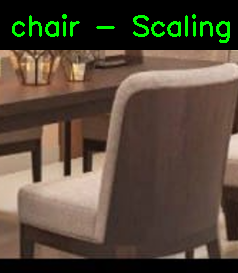

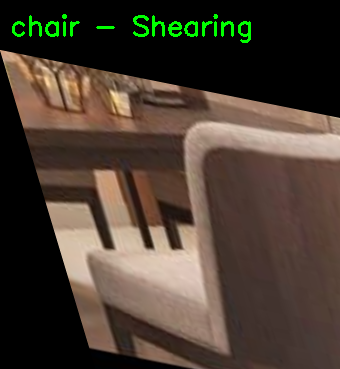

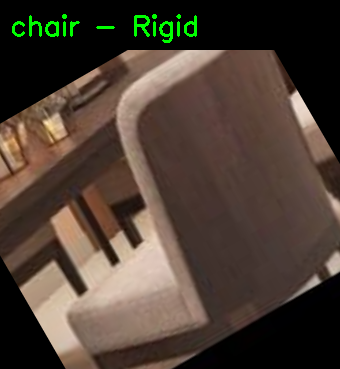

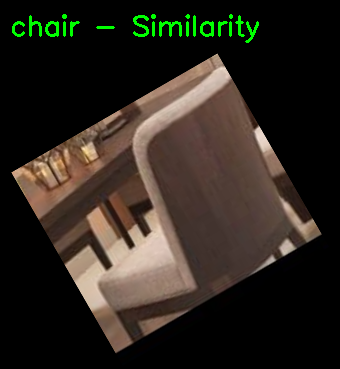

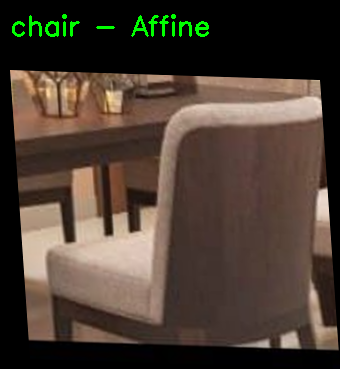

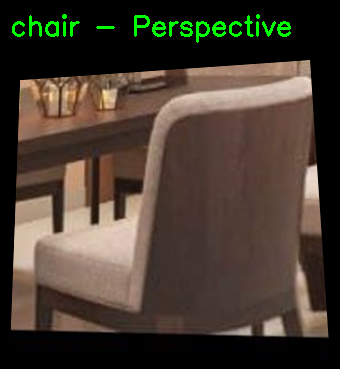

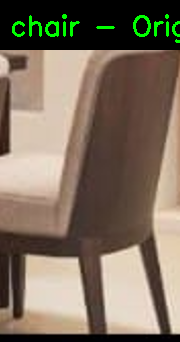

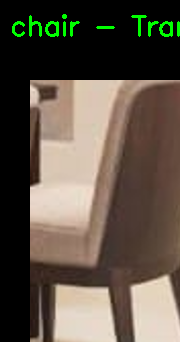

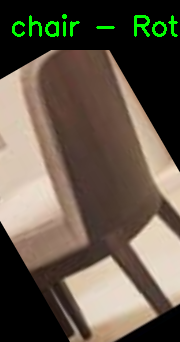

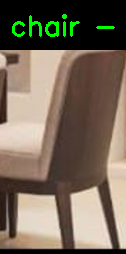

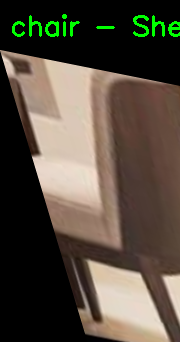

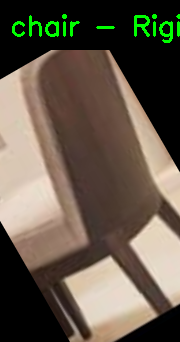

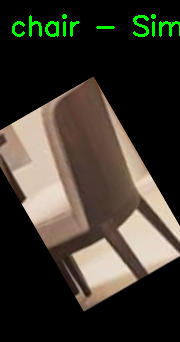

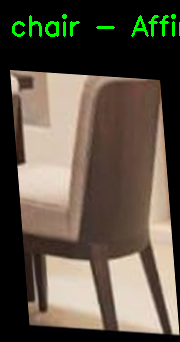

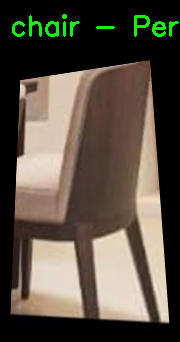

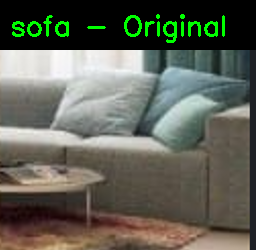

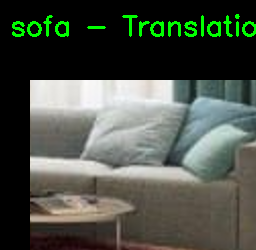

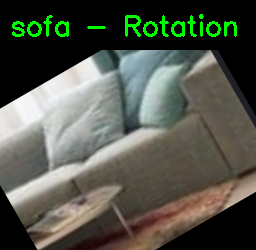

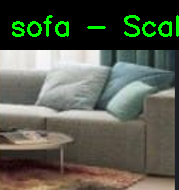

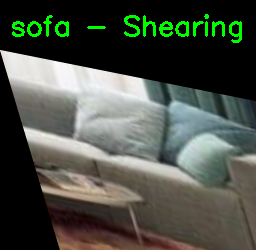

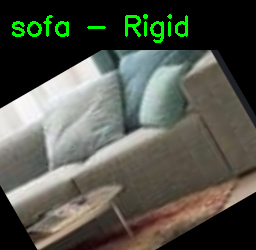

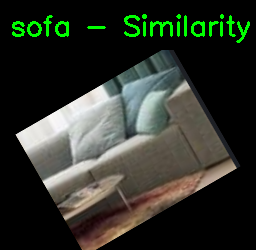

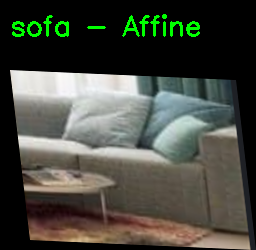

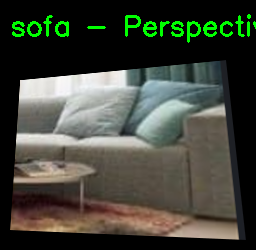

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# ---------- SHOW FUNCTION (TITLE WITH SPACE) ----------
def show(img, title):
    h, w = img.shape[:2]
    padded = np.zeros((h + 50, w, 3), dtype=np.uint8)
    padded[50:, :] = img

    cv2.putText(padded, title, (10, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                (0, 255, 0), 2)

    cv2_imshow(padded)

# ---------- CLASS LABELS ----------
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow",
           "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

# ---------- LOAD MODEL ----------
net = cv2.dnn.readNetFromCaffe(
    "MobileNetSSD_deploy.prototxt",
    "MobileNetSSD_deploy (1).caffemodel"
)

# ---------- LOAD IMAGE ----------
img = cv2.imread("Screenshot (9).png")
if img is None:
    raise ValueError("Image not found")

H, W = img.shape[:2]

# ---------- OBJECT DETECTION ----------
blob = cv2.dnn.blobFromImage(
    cv2.resize(img, (300, 300)),
    0.007843, (300, 300), 127.5
)

net.setInput(blob)
detections = net.forward()

# ---------- LOOP THROUGH OBJECTS ----------
for i in range(detections.shape[2]):
    conf = detections[0, 0, i, 2]

    if conf > 0.5:
        idx = int(detections[0, 0, i, 1])
        label = CLASSES[idx]

        box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
        x1, y1, x2, y2 = box.astype(int)

        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W, x2), min(H, y2)

        obj = img[y1:y2, x1:x2]
        if obj.size == 0:
            continue

        h, w = obj.shape[:2]

        # Original
        show(obj, f"{label} - Original")

        # Translation
        M_t = np.float32([[1, 0, 30],
                          [0, 1, 30]])
        show(cv2.warpAffine(obj, M_t, (w, h)),
             f"{label} - Translation")

        # Rotation
        M_r = cv2.getRotationMatrix2D((w//2, h//2), 30, 1)
        show(cv2.warpAffine(obj, M_r, (w, h)),
             f"{label} - Rotation")

        # Scaling
        show(cv2.resize(obj, None, fx=0.7, fy=0.7),
             f"{label} - Scaling")

        # Shearing
        M_sh = np.float32([[1, 0.3, 0],
                           [0.2, 1, 0]])
        show(cv2.warpAffine(obj, M_sh, (w, h)),
             f"{label} - Shearing")

        # Rigid (Euclidean)
        show(cv2.warpAffine(obj, M_r, (w, h)),
             f"{label} - Rigid")

        # Similarity
        M_sim = cv2.getRotationMatrix2D((w//2, h//2), 30, 0.7)
        show(cv2.warpAffine(obj, M_sim, (w, h)),
             f"{label} - Similarity")

        # Affine
        pts1 = np.float32([[0, 0], [w, 0], [0, h]])
        pts2 = np.float32([[10, 20], [w-20, 30], [30, h-10]])
        M_aff = cv2.getAffineTransform(pts1, pts2)
        show(cv2.warpAffine(obj, M_aff, (w, h)),
             f"{label} - Affine")

        # ---------- PERSPECTIVE TRANSFORMATION ----------
        pts1_p = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        pts2_p = np.float32([[20, 30], [w-30, 10],
                             [10, h-20], [w-10, h-10]])

        M_p = cv2.getPerspectiveTransform(pts1_p, pts2_p)
        perspective = cv2.warpPerspective(obj, M_p, (w, h))
        show(perspective, f"{label} - Perspective")